# **Config**

In [1]:
!pip install -q pysastrawi
!pip install -q nltk
!pip install -q catboost
!pip install -q xgboost
!pip install -q imbalanced-learn
!pip install -q deep_translator
!pip install -q tensorflow_text tensorflow_hub
!pip install -q tf-keras
!pip install -q transformers
!pip install -q gradio-client
!pip install -q deep_translator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 668.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import sklearn
import plotly
import keras
import nltk
import Sastrawi
import re
import wordcloud
import string
import torch
import imblearn
import deep_translator
import json
import requests
import concurrent.futures
import itertools
import csv
import random

import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import tf_keras as tfk
import tensorflow_hub as tfhub
import tensorflow_text as tftext

from nltk.corpus import wordnet
from torch import nn
from deep_translator import GoogleTranslator
from gradio_client import Client
from tqdm import tqdm
from bs4 import BeautifulSoup
from multiprocessing import Pool
from imblearn.over_sampling import RandomOverSampler, SMOTE
from wordcloud import WordCloud, STOPWORDS
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from tqdm.auto import tqdm

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import balanced_accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import (
    AutoModelForSequenceClassification,
    get_scheduler,
    RobertaTokenizer,
    TFAutoModel,
    AdamWeightDecay,
    AdamW,
    BertTokenizer,
    TFBertModel,
    AutoTokenizer,
    AutoModel,
    DistilBertTokenizer,
    TFDistilBertModel
)
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import os
os.environ['TF_USE_LEGACY_KERAS'] = "1"

import warnings
warnings.filterwarnings('ignore')

# **Prepare Dataset**

In [3]:
train_df = pd.read_csv('https://raw.githubusercontent.com/akmalmzkki/satriadata/main/dataset_penyisihan_bdc_2024.csv')
test_df = pd.read_csv('https://raw.githubusercontent.com/akmalmzkki/satriadata/main/dataset_unlabeled_penyisihan_bdc_2024.csv')
train_df['text'] = train_df['text'].astype(np.str_)
test_df['text'] = test_df['text'].astype(np.str_)

In [ ]:
# Duplikasi per baris
duplicates = train_df[train_df.duplicated(keep=False)]
duplicates['duplicate_key'] = duplicates.apply(lambda row: tuple(row), axis=1)
grouped_duplicates = duplicates.groupby('duplicate_key')
for key, group in grouped_duplicates:
    print(key, group)
    print("\n")

In [ ]:
# Duplikasi text sama label berbeda
grouped_by_text = train_df.groupby('text')

groups_with_different_labels = []

for text, group in grouped_by_text:
    if group['label'].nunique() > 1:
        groups_with_different_labels.append(group)

for group in groups_with_different_labels:
    print(group)
    print("\n")

In [4]:
train_df.drop_duplicates(subset=['text', 'label'], keep='first', inplace=True)

# **Visualize Data**

## **Label Distribution**

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x = train_df['label'].value_counts().index,
    y = train_df['label'].value_counts().values,
    marker_color=px.colors.qualitative.Dark24,
))

fig.update_layout(
    title = 'Banyak Data pada Data Target',
    xaxis_title = 'Data Target',
    yaxis_title = 'Banyak Data'
)

fig.show()

## **Text Distribution**

In [ ]:
def get_top_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)

    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

    words, freqs = zip(*words_freq)

    plt.figure(figsize=(n, n//2))
    sns.barplot(x=freqs, y=words, palette='viridis')

    for i, txt in enumerate(freqs):
        plt.text(txt, i, txt, ha='left', va='center', color='black')

    plt.title(f'Top {n} {g}-grams')
    plt.xlabel('Frequency')
    plt.ylabel(f'{g}-grams')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='x')
    plt.show()

In [ ]:
def get_top_unigram_based_on_label(corpus, n):
    labels = corpus['label'].unique().tolist()
    num_labels = len(labels)

    ncols = 3
    nrows = (num_labels + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 12))
    axes = axes.flatten()

    for i, label in enumerate(labels):
        vec = CountVectorizer(ngram_range=(1, 1)).fit(corpus[corpus['label'] == label]['text'])
        bag_of_words = vec.transform(corpus[corpus['label'] == label]['text'])

        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

        words, freqs = zip(*words_freq)

        sns.barplot(x=list(freqs), y=list(words), palette='viridis', ax=axes[i])

        axes[i].set_title(f'Top {n} unigrams in {label}')
        axes[i].set_xlabel('Frequency')
        axes[i].set_ylabel('Unigrams')
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].tick_params(axis='y', rotation=45)
        axes[i].grid(axis='x')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [ ]:
def visualize_word_cloud(df):
    labels = df['label'].unique().tolist()
    num_labels = len(labels)

    ncols = 3
    nrows = (num_labels + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 12))
    axes = axes.flatten()

    for i, label in enumerate(labels):
        text_data = " ".join(df[df['label'] == label].text)
        wc = WordCloud(max_words=2000, width=800, height=400, stopwords=STOPWORDS, margin=1).generate(text_data)
        axes[i].imshow(wc, interpolation='bilinear')
        axes[i].set_title(label)
        axes[i].axis('off')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# **Text Preprocessing**

## **Find OOV**

In [ ]:
def cek_kata_di_kbbi(kata):
    url = f"https://kbbi.web.id/{kata}"
    try:
        response = requests.get(url, timeout=10)
        if response.status_code != 200:
            return False
        soup = BeautifulSoup(response.text, 'html.parser')
        d1_element = soup.find('div', id='d1')
        if d1_element and not d1_element.text.strip():
            return False
        return True
    except requests.exceptions.RequestException:
        return False

kata_train = list(set(" ".join(train_df['text'].tolist()).split()))
kata_test = list(set(" ".join(test_df['text'].tolist()).split()))

kata_kata = list(set(kata_train + kata_test))

kata_oov = []
max_workers = 20
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = {executor.submit(cek_kata_di_kbbi, kata): kata for kata in kata_kata}
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Mengecek kata di KBBI"):
        kata = futures[future]
        if not future.result():
            kata_oov.append(kata)

set_kata_oov = list(set(kata_oov))
print(f"Kata OOV: {set_kata_oov}")

Mengecek kata di KBBI:   0%|          | 0/8517 [00:00<?, ?it/s]

Kata OOV: ['lemdiklat', 'lahin', 'tuanrakyat', 'ganjarpekerjamigran', 'persokongkolan', 'chairman', 'adsnya', 'paraaaaahhhhh', 'tolakkoalisianesbasyir', 'effect', 'ciamis', 'nadiem', 'hoaks', 'indonesiaemas', 'gemoynya', 'carlos', 'despite', 'mnangdebat', 'miss', 'freind', 'kitankdye', 'zenius', 'nyeleksi', 'chaniago', 'jetika', 'indonesiamaju', 'nailing', 'korantempo', 'prabs', 'really', 'masbowogbran', 'dibw', 'realita', 'loud', 'intansi', 'omon', 'gopolitik', 'sahroni', 'compared', 'bagibagi', 'prescon', 'ahmadyani', 'imin', 'inspiratif', 'disanakalian', 'mission', 'beberin', 'kanjnk', 'papuamasya', 'aibon', 'faisal', 'brin', 'methods', 'syaugi', 'tabaraqallah', 'ngadi', 'location', 'iminamptiem', 'stikptik', 'politikgen', 'branding', 'pipapipa', 'merobekrobek', 'muzakirmanaf', 'cooling', 'inshaalloh', 'berpartispasi', 'dissing', 'lalalalala', 'pembangunanjnke', 'nerotumilena', 'leimena', 'desakslepetamin', 'aith', 'mengupload', 'xavi', 'nelayankeluar', 'menkopolhukam', 'award', 'kl

In [ ]:
with open('oov-fiks.txt', 'w', encoding='utf-8') as file:
    for kata in set_kata_oov:
        file.write(kata + '\n')

print("Kata OOV telah disimpan ke dalam file 'oov.txt'")

Kata OOV telah disimpan ke dalam file 'oov.txt'


## **Spell Checker**

In [ ]:
oov = pd.read_csv('oov-fiks.txt', header=None, names=['oov'])
oov.to_csv('oov-fiks.csv', index=False)

In [ ]:
def qwen2(message):
    client = Client("Qwen/Qwen2-72B-Instruct")
    result = client.predict(
        query=message,
        history=[],
        system=f"text yang diinputkan adalah teks out of vocabulary, tuliskan revisi dari teks out of vocabulary tersebut menggunakan bahasa indonesia, atau tulis 'tidak diketahui' jika tidak ada arti dari teks tersebut menggunakan huruf kecil semua. Kamu hanya berhak menuliskan outputnya dalam 1 kata saja, tidak boleh menuliskan kata kata lainnya selain teks hasil revisi tersebut",
        api_name="/model_chat"
    )
    return result[1][0][1]

In [ ]:
with open("oov-fiks.csv", "r") as csvfile:
    reader = csv.DictReader(csvfile)

    fieldnames = [field for field in reader.fieldnames if field not in ["true"]]
    fieldnames.append("true")

    with open("oov-true.csv", "w", newline="") as outfile:
        writer = csv.DictWriter(outfile, fieldnames=fieldnames)
        writer.writeheader()

        for i, row in enumerate(reader):
            tweet = row["oov"]
            prompt_label = f"text '{tweet}' adalah teks oov, tuliskan hanya kata yang benar dari oov tersebut, atau tulis 'tidak diketahui' jika tidak ada arti dari teks tersebut. Kamu hanya berhak menuliskan outputnya dalam 1 kata saja"

            row["prompt_qwen"] = prompt_label

            try:
                response = qwen2(tweet)
                print(f"{i+1}: {response}")
            except Exception as e:
                print("Exception occurred during conversation:", e)
                response = None

            row.pop("prompt_qwen", None)

            if response is None:
                print("response is None")
                row["true"] = "No Label"
            else:
                row["true"] = response

            writer.writerow(row)

## **Handling OOV**

In [5]:
url1 = "https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv"
url2 = 'https://raw.githubusercontent.com/ramaprakoso/analisis-sentimen/master/kamus/kbba.txt'
url3 = "https://raw.githubusercontent.com/okkyibrohim/id-multi-label-hate-speech-and-abusive-language-detection/master/new_kamusalay.csv"
url4 = "https://raw.githubusercontent.com/ramaprakoso/analisis-sentimen/master/kamus/acronym.txt"
url5 = "https://raw.githubusercontent.com/panggi/pujangga/master/resource/formalization/formalizationDict.txt"
url6 = "https://raw.githubusercontent.com/yasirutomo/python-sentianalysis-id/master/data/feature_list/stopwordsID.txt"
url7 = "https://raw.githubusercontent.com/akmalmzkki/satriadata/main/combined_slang_word.txt"
url8 = "https://raw.githubusercontent.com/akmalmzkki/satriadata/main/slang.txt"
url9 = 'https://raw.githubusercontent.com/akmalmzkki/satriadata/main/oov-true.csv'

oov = pd.read_csv(url9, delimiter=";")
oov['kalimat_true'] = oov['kalimat_true'].replace({'tidak diketahui':" "})
oov = dict(zip(oov['oov'], oov['kalimat_true']))
print(len(oov), type(oov))

slang = pd.read_csv(url8, sep=' : ', header=None)
slang.dropna(inplace=True)
slang = slang.rename(columns={0: 'original', 1: 'replacement'})
slang1 = dict(zip(slang['original'], slang['replacement']))
print(len(slang1), type(slang1))

combined_slang = pd.read_json(url7, orient='index')
slang2 = combined_slang[0].to_dict()
print(len(slang2), type(slang2))

kamusalay = pd.read_csv(url3, header=None, names=['slang', 'formal'], encoding='ISO-8859-1')
kamusalay.dropna(inplace=True)
slang3 = dict(zip(kamusalay['slang'], kamusalay['formal']))
print(len(slang3), type(slang3))

kbba = pd.read_csv(url2, sep='\t', header=None, names=['singkat', 'formal'])
kbba.dropna(inplace=True)
slang4 = dict(zip(kbba['singkat'], kbba['formal']))
print(len(slang4), type(slang4))

lexicon = pd.read_csv(url1)
lexicon.dropna(inplace=True)
lexicon = lexicon[['slang', 'formal']]
slang5 = dict(zip(lexicon['slang'], lexicon['formal']))
print(len(slang5), type(slang5))

formalization = pd.read_csv(url5, sep='\t', header=None, names=['slang', 'formal'])
formalization.dropna(inplace=True)
slang6 = dict(zip(formalization['slang'], formalization['formal']))
print(len(slang6), type(slang6))

4191 <class 'dict'>
1620 <class 'dict'>
1018 <class 'dict'>
15167 <class 'dict'>
1290 <class 'dict'>
4331 <class 'dict'>
1135 <class 'dict'>


In [6]:
combined_slang = {**slang1, **slang2, **slang3, **slang4, **slang5, **slang6, **oov}
combined_slang = pd.DataFrame(combined_slang.items(), columns=['original', 'replacement'])
combined_slang = dict(zip(combined_slang['original'], combined_slang['replacement']))
print(len(combined_slang), type(combined_slang))

20562 <class 'dict'>


In [7]:
stopwords_id = pd.read_csv(url6, header=None, names=['stopword'])
stopwords_id = stopwords_id['stopword'].tolist()
print(len(stopwords_id), type(stopwords_id))

758 <class 'list'>


## **Feature Extraction**

In [8]:
def informal_to_formal_indo(slang, text):
    res = " ".join(slang.get(ele, ele) for ele in text.split())
    return res

def cleaning_text(text):
    text = re.sub(r'x00[0-9a-fA-F]{2}', '', text)           # Menghapus pola x00XX
    text = re.sub(r'[^\x00-\x7F]+', '', text)               # remove non-ascii characters (emoticon, emoji, etc.)
    text = re.sub(r'\[RE [^\]]+\]', '', text)               # remove RE
    text = re.sub(r'@[A-Za-z0-9+/=]+', '', text)            # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text)               # remove hashtag
    text = re.sub(r'<[^>]+>', '', text)                     # remove HTML tags
    text = re.sub(r'RT[\s]', '', text)                      # remove RT
    text = re.sub(r"http\S+", '', text)                     # remove link
    text = re.sub(r'[0-9]+', '', text)                      # remove numbers
    text = re.sub(r'\n', ' ', text)                         # remove newline
    text = re.sub(r'[^\w\s]', '', text)                     # remove all punctuations
    text = re.sub(r'[%-+]', ' ', text)                      # Menghapus karakter %, - dan +
    text = re.sub(r'^\s+|\s+$', '', text)                   # remove characters space from both left and right text
    text = text.lower()                                     # convert text into lowercase
    text = informal_to_formal_indo(combined_slang, text)    # convert informal words into formal words
    text = re.sub(r'anies|baswedan|imin|prabowo|subianto|ganjar|pranowo|mahfud|md|gibran|rakabuming|jokowi|joko|widodo', ' ', text)
    text = text.lower()                                     # convert text into lowercase
    text = re.sub(r' +', ' ', text)                         # remove extra spaces
    return text

def tokenizing_text(text):
    return word_tokenize(text)

def stop_word_text(text):
    stopword = StopWordRemoverFactory().get_stop_words() + stopwords.words('indonesian') + stopwords_id
    stopword = list(set(stopword))
    stopword = [word.lower() for word in stopword]
    split_text = text.split() if isinstance(text, str) else text
    return [word for word in split_text if word not in stopword]

def stemming_text(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = [stemmer.stem(word) for word in text]
    return text

def combined_text(text):
    return ' '.join(text)

In [9]:
nltk.download('stopwords')
nltk.download('punkt')

def apply_preprocess(df):
    df['text'] = df['text'].apply(cleaning_text)
    df['text'] = df['text'].apply(tokenizing_text)
    df['text'] = df['text'].apply(stop_word_text)
    df['text'] = df['text'].apply(stemming_text)
    df['text'] = df['text'].apply(combined_text)

apply_preprocess(train_df)
apply_preprocess(test_df)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Duplikasi per baris
duplicates = train_df[train_df.duplicated(keep=False)]
duplicates['duplicate_key'] = duplicates.apply(lambda row: tuple(row), axis=1)
grouped_duplicates = duplicates.groupby('duplicate_key')
for key, group in grouped_duplicates:
    print(key, group)
    print("\n")

In [ ]:
# Duplikasi text sama label berbeda
grouped_by_text = train_df.groupby('text')

groups_with_different_labels = []

for text, group in grouped_by_text:
    if group['label'].nunique() > 1:
        groups_with_different_labels.append(group)

for group in groups_with_different_labels:
    print(group)
    print("\n")

     text             label
74            Sosial Budaya
552                 Politik
943           Sosial Budaya
1157                Politik
1952               Geografi
1970       Sumber Daya Alam
2648                Politik
2660       Sumber Daya Alam
3307                Ekonomi
3891                Politik
3929                Politik
4783          Sosial Budaya




In [10]:
train_df = train_df[train_df['text'] != ""]
train_df.drop_duplicates(subset=['text', 'label'], keep='first', inplace=True)

## **Get Top N-Grams**

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x = train_df['label'].value_counts().index,
    y = train_df['label'].value_counts().values,
    marker_color=px.colors.qualitative.Dark24,
))

fig.update_layout(
    title = 'Banyak Data pada Data Target',
    xaxis_title = 'Data Target',
    yaxis_title = 'Banyak Data'
)

fig.show()

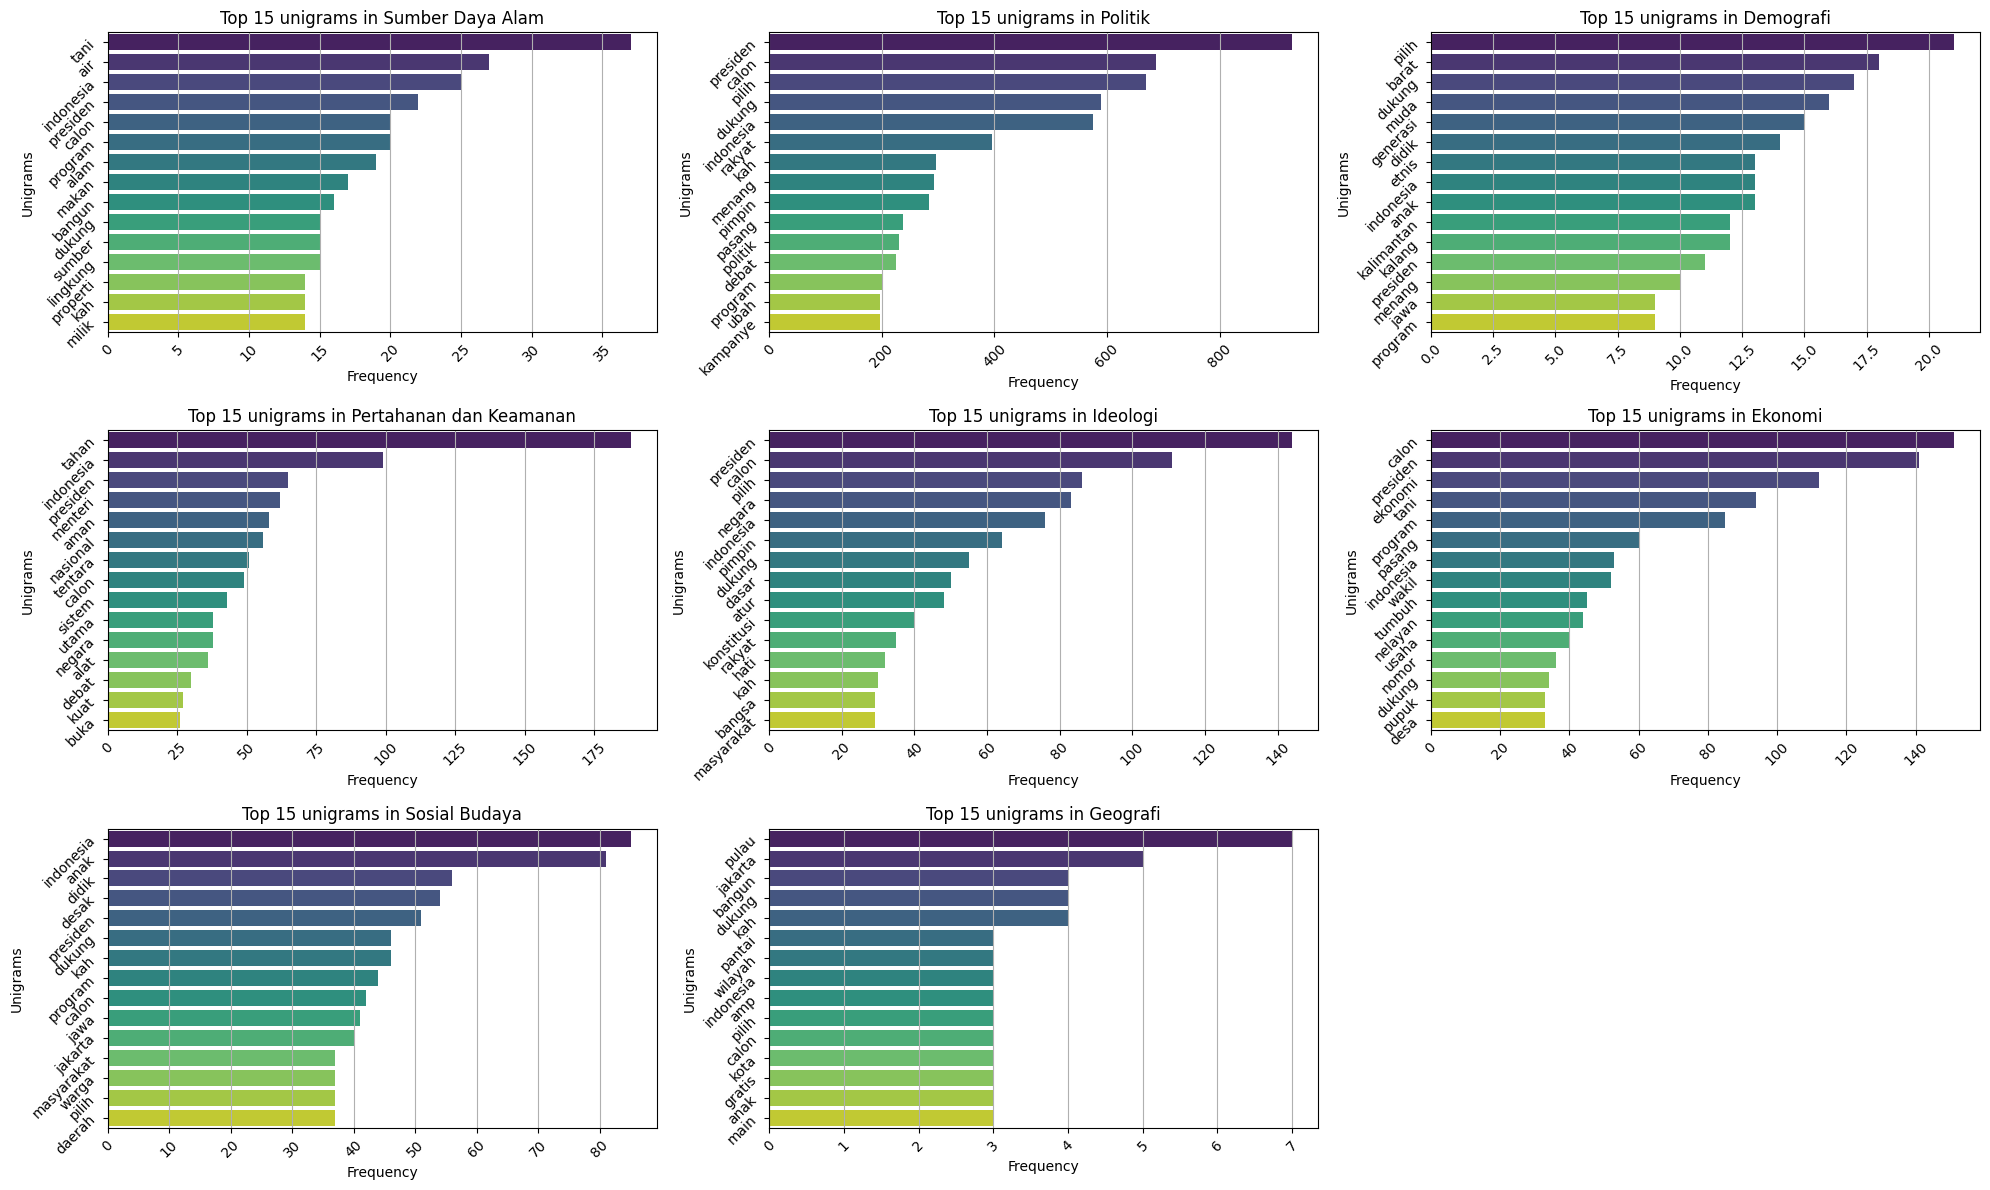

In [ ]:
get_top_unigram_based_on_label(train_df, 15)

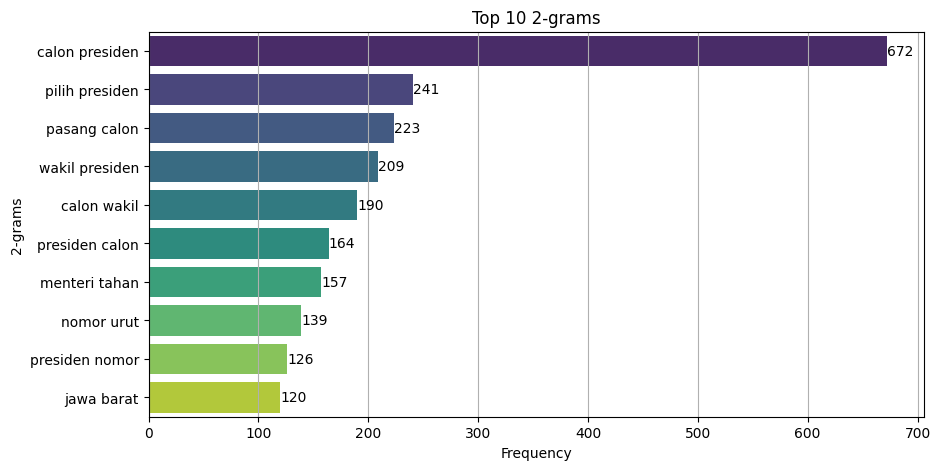

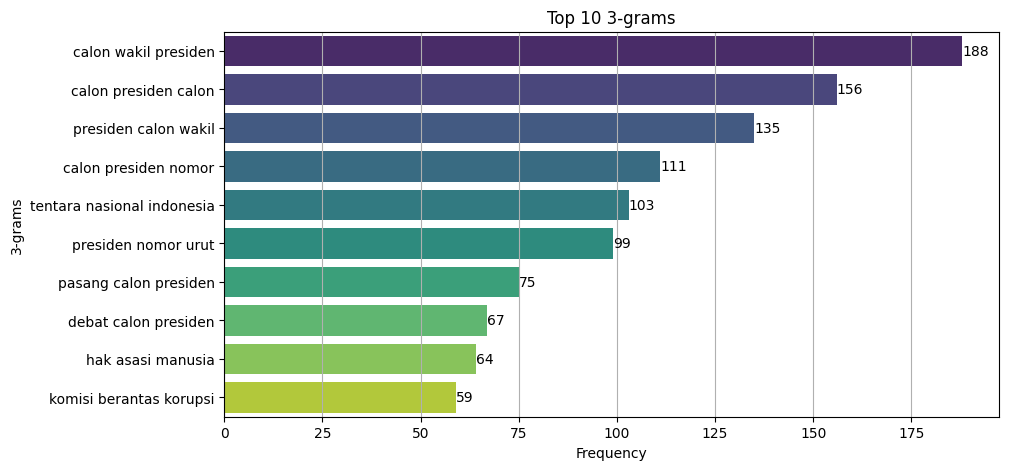

In [ ]:
get_top_ngrams(train_df['text'], 10, 2)
get_top_ngrams(train_df['text'], 10, 3)

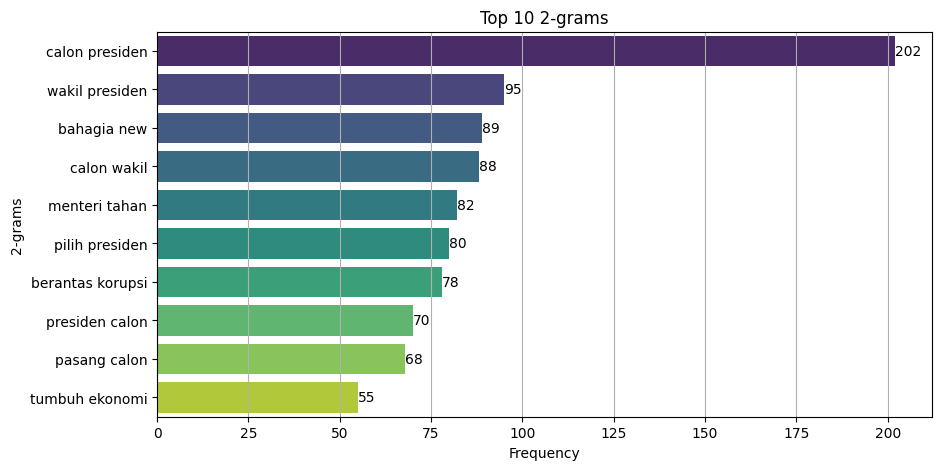

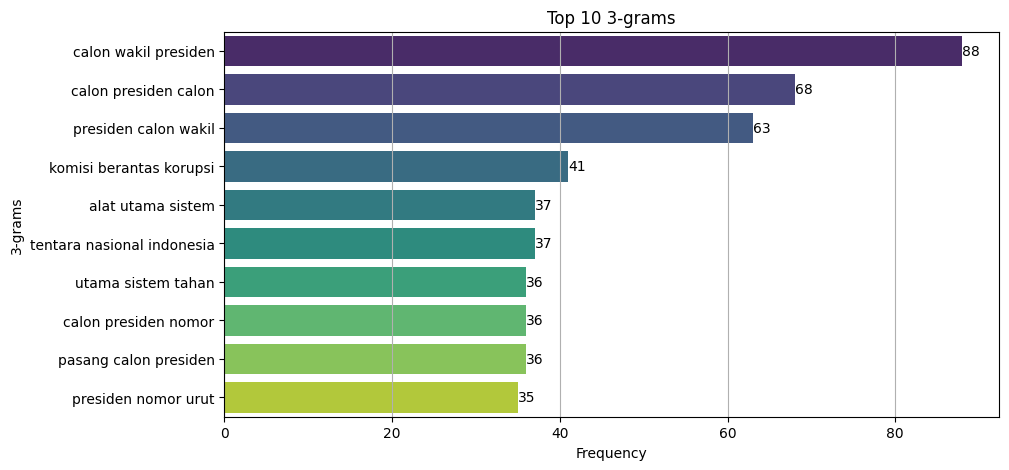

In [ ]:
get_top_ngrams(test_df['text'], 10, 2)
get_top_ngrams(test_df['text'], 10, 3)

## **Word Cloud**

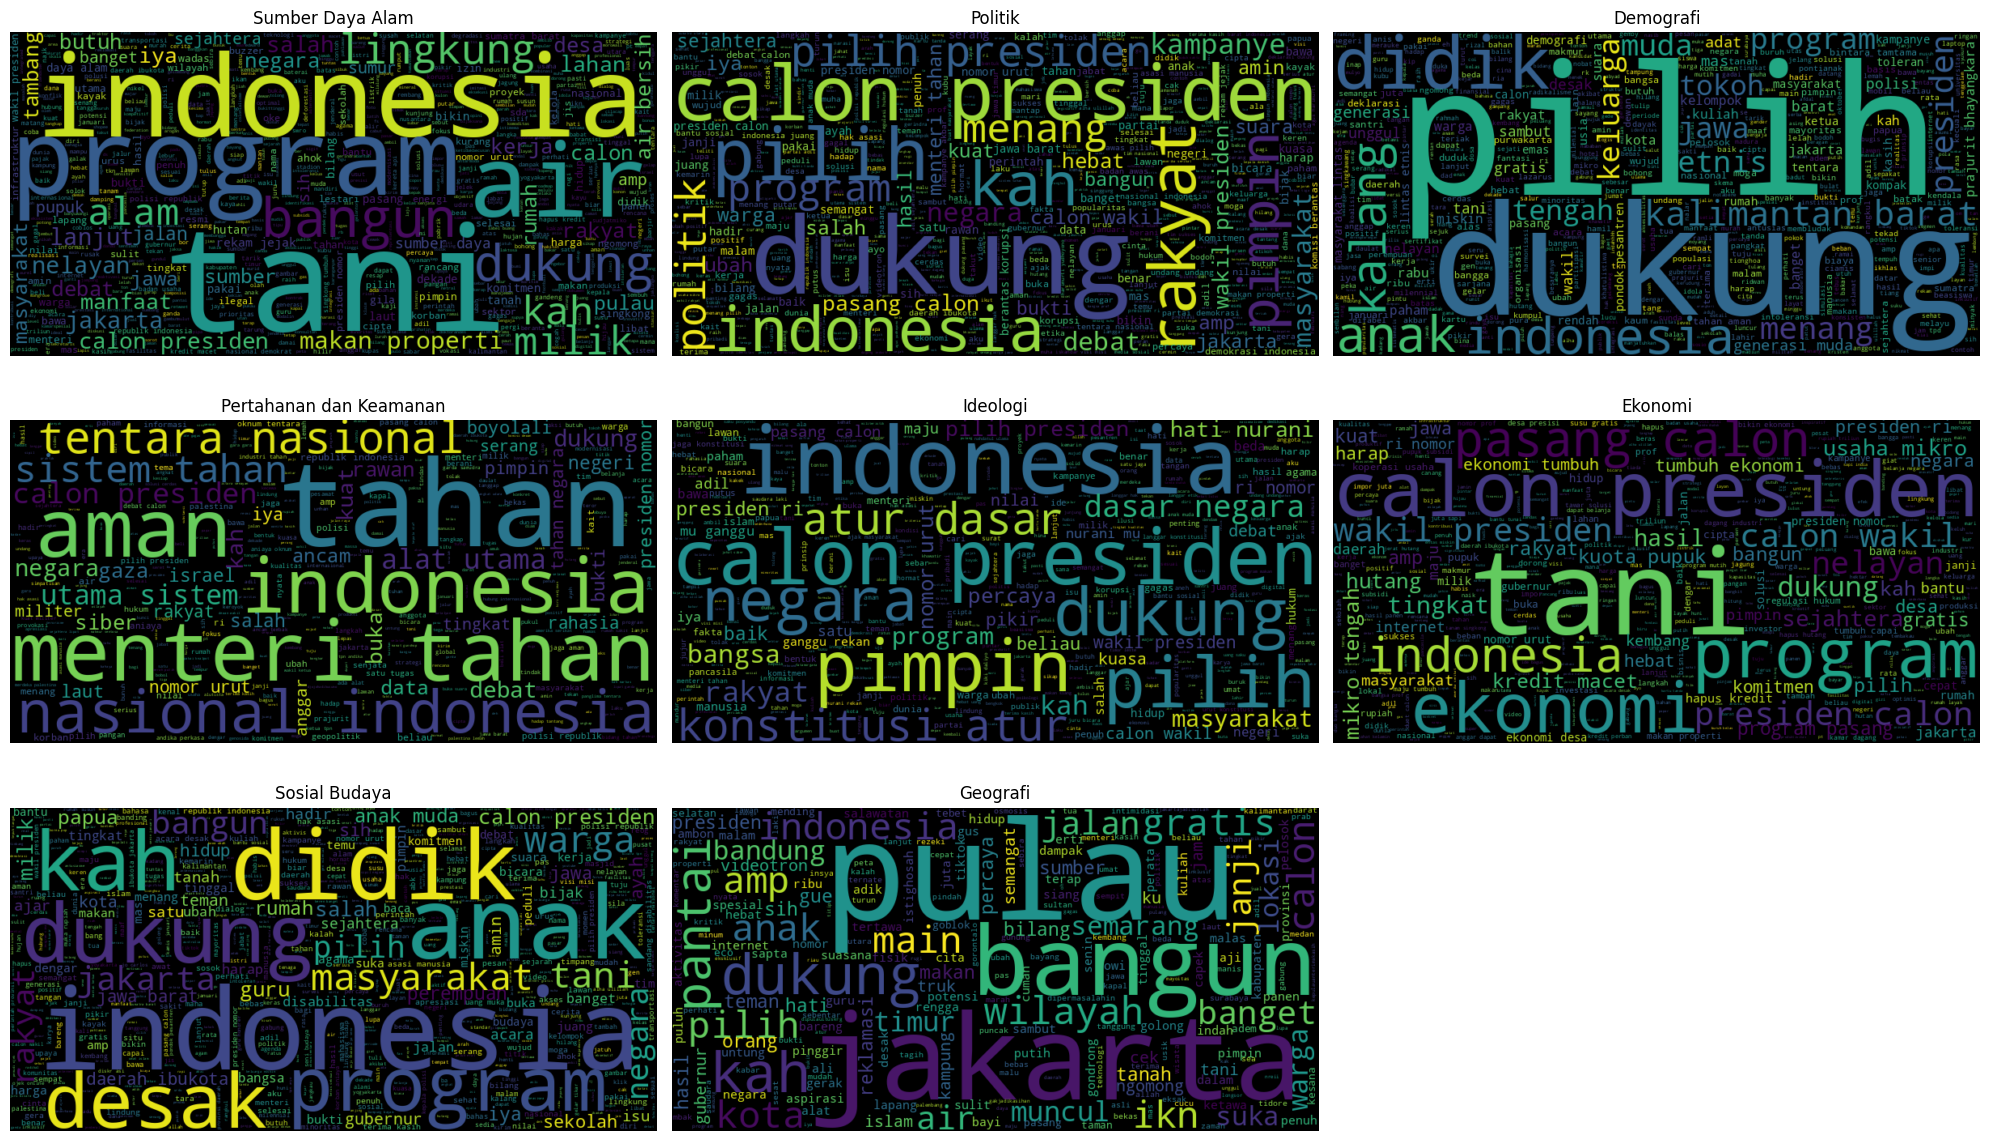

In [ ]:
visualize_word_cloud(train_df)

In [11]:
train_df.to_csv("./cleaned_dataset_penyisihan_bdc_2024.csv", index=False)
test_df.to_csv("./cleaned_dataset_unlabeled_penyisihan_bdc_2024.csv", index=False)

# **Text Modelling**

In [12]:
train_df = pd.read_csv("./cleaned_dataset_penyisihan_bdc_2024.csv")
test_df = pd.read_csv("./cleaned_dataset_unlabeled_penyisihan_bdc_2024.csv")
train_df.dropna(inplace=True)

## **Word Importance**

In [ ]:
def count_unique_words(train_df):
    unique_word_counts = {}

    grouped = train_df.groupby('label')

    for label, group in grouped:
        text_data = group['text'].str.cat(sep=' ')
        words = set(text_data.split())
        unique_word_counts[label] = len(words)

    sorted_counts = {k: v for k, v in sorted(unique_word_counts.items(), key=lambda item: item[1], reverse=True)}

    return sorted_counts

unique_words = count_unique_words(train_df)
unique_words

{'Politik': 4838,
 'Sosial Budaya': 2035,
 'Ideologi': 1573,
 'Pertahanan dan Keamanan': 1412,
 'Ekonomi': 1027,
 'Sumber Daya Alam': 869,
 'Demografi': 566,
 'Geografi': 232}

In [ ]:
def apply_word_frequency_train(train_df):
    label_words = {
        'Politik': [],
        'Sosial Budaya': [],
        'Ekonomi': [],
        'Pertahanan dan Keamanan': [],
        'Ideologi': [],
        'Sumber Daya Alam': [],
        'Demografi': [],
        'Geografi': []
    }

    grouped = train_df.groupby('label')

    for label, group in grouped:
        text_data = group['text'].str.cat(sep=' ')
        words = text_data.split()
        word_freq = Counter(words)

        if label == 'Politik':
            label_words['Politik'] = [word for word, _ in word_freq.most_common(int(unique_words['Politik']/16))]
        elif label == 'Sosial Budaya':
            label_words['Sosial Budaya'] = [word for word, _ in word_freq.most_common(int(unique_words['Sosial Budaya']/14))]
        elif label == 'Ideologi':
            label_words['Ideologi'] = [word for word, _ in word_freq.most_common(int(unique_words['Ideologi']/12))]
        elif label == 'Pertahanan dan Keamanan':
            label_words['Pertahanan dan Keamanan'] = [word for word, _ in word_freq.most_common(int(unique_words['Pertahanan dan Keamanan']/10))]
        elif label == 'Ekonomi':
            label_words['Ekonomi'] = [word for word, _ in word_freq.most_common(int(unique_words['Ekonomi']/8))]
        elif label == 'Sumber Daya Alam':
            label_words['Sumber Daya Alam'] = [word for word, _ in word_freq.most_common(int(unique_words['Sumber Daya Alam']/6))]
        elif label == 'Demografi':
            label_words['Demografi'] = [word for word, _ in word_freq.most_common(int(unique_words['Demografi']/4))]
        elif label == 'Geografi':
            label_words['Geografi'] = [word for word, _ in word_freq.most_common(int(unique_words['Geografi']/2))]

    return label_words

label_words = apply_word_frequency_train(train_df.copy())

list_all_important = []
for words in label_words.values():
    list_all_important.extend(words)

list_all_important = list(set(list_all_important))

def filter_important_words(text, important_list):
    return ' '.join([word for word in text.split() if word in important_list])

In [ ]:
train_df['text'] = train_df['text'].apply(lambda x: filter_important_words(x, list_all_important))
test_df['text'] = test_df['text'].apply(lambda x: filter_important_words(x, list_all_important))

In [ ]:
train_df.to_csv("./cleaned_dataset_penyisihan_bdc_2024.csv", index=False)
test_df.to_csv("./cleaned_dataset_unlabeled_penyisihan_bdc_2024.csv", index=False)

## **Back Translation**

In [15]:
def translate_text(text):
    translated_text = GoogleTranslator(source='en', target='id').translate(text)
    return translated_text.lower()

def apply_back_translation(df, num_workers=20):
    texts = df['text'].tolist()
    translated_texts = []

    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        future_to_text = {executor.submit(translate_text, text): text for text in texts}
        for future in tqdm(concurrent.futures.as_completed(future_to_text), total=len(texts)):
            translated_texts.append(future.result())

    df['text'] = translated_texts
    return df

train_df = apply_back_translation(train_df)
test_df = apply_back_translation(test_df)

  0%|          | 0/4244 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [17]:
train_df.to_csv("./cleaned_dataset_penyisihan_bdc_2024.csv", index=False)
test_df.to_csv("./cleaned_dataset_unlabeled_penyisihan_bdc_2024.csv", index=False)

## **Synonim Replacement**

In [ ]:
train_df = pd.read_csv("./cleaned_dataset_penyisihan_bdc_2024.csv")
test_df = pd.read_csv("./cleaned_dataset_unlabeled_penyisihan_bdc_2024.csv")
train_df.dropna(inplace=True)

In [ ]:
nltk.download('wordnet')

def synonym_replacement(sentence, n):
    words = sentence.split()
    new_sentence = words.copy()
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
    random.shuffle(random_word_list)
    num_replaced = 0

    for random_word in random_word_list:
        synonyms = wordnet.synsets(random_word)
        if synonyms:
            synonym = random.choice(synonyms).lemmas()[0].name()
            new_sentence = [synonym if word == random_word else word for word in new_sentence]
            num_replaced += 1
        if num_replaced >= n:
            break
    return ' '.join(new_sentence)

def augment_minority_class(df, n_replacements=2):
    augmented_texts = []
    augmented_labels = []

    for label in df['label'].unique():
        subset = df[df['label'] == label]
        if len(subset) < df['label'].value_counts().max():
            num_to_generate = df['label'].value_counts().max() - len(subset)
            for _ in range(num_to_generate):
                row = subset.sample(n=1).iloc[0]
                augmented_text = synonym_replacement(row['text'], n_replacements)
                augmented_texts.append(augmented_text)
                augmented_labels.append(row['label'])

    return pd.DataFrame({
        'text': augmented_texts,
        'label': augmented_labels
    })

train_df = pd.concat([
    train_df,
    augment_minority_class(train_df)
])

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
train_df.drop_duplicates(inplace=True)
train_df['label'].value_counts()

label
Politik                    2818
Sosial Budaya               875
Ekonomi                     816
Ideologi                    624
Pertahanan dan Keamanan     595
Sumber Daya Alam            473
Demografi                   220
Geografi                    144
Name: count, dtype: int64

## **Prepare Dataset**

In [ ]:
def encode_target(target):
    target_tensor = tf.constant(target)

    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            keys=tf.constant([
                'Politik', 'Sosial Budaya',
                'Ideologi', 'Pertahanan dan Keamanan',
                'Geografi', 'Ekonomi',
                'Sumber Daya Alam', 'Demografi'
            ]),
            values=tf.constant([0, 1, 2, 3, 4, 5, 6, 7]),
        ),
        default_value=tf.constant(-1),
        name="target_encoding"
    )

    return table.lookup(target_tensor)

def fetch(text, label):
    label = tf.cast(label, tf.int32)
    encoded_label = tf.one_hot(label, 8)
    return text, encoded_label

In [ ]:
X_train, X_test = train_test_split(train_df.dropna(), test_size=0.2, random_state=None)

X_train['text'], X_train['label'] = X_train['text'].astype(str), encode_target(X_train['label'].tolist()).numpy()
X_test['text'], X_test['label'] = X_test['text'].astype(str), encode_target(X_test['label'].tolist()).numpy()

train_dataset = tf.data.Dataset.from_tensor_slices(
    (X_train['text'].values, X_train['label'])
).map(lambda text, label: fetch(text, label))

test_dataset = tf.data.Dataset.from_tensor_slices(
    (X_test['text'].values, X_test['label'])
).map(lambda text, label: fetch(text, label))

train_data, train_label = next(iter(train_dataset.batch(len(train_dataset))))
test_data, test_label = next(iter(test_dataset.batch(len(test_dataset))))

train_data = np.asarray([data.decode('utf-8') for data in np.asarray(train_data)])
train_label = np.asarray(train_label)
test_data = np.asarray([data.decode('utf-8') for data in np.asarray(test_data)])
test_label = np.asarray(test_label)

class_weights = compute_class_weight(
    class_weight ='balanced',
    classes=np.unique(X_train['label']),
    y=X_train['label']
)

class_weights = dict(zip(np.unique(X_train['label']), class_weights))

# **Model Training**

## **Using Simple RNN**

In [ ]:
tfk.backend.clear_session()

encoder = tfk.layers.TextVectorization(max_tokens=1200)
encoder.adapt(train_data)

stacked_bi_lstm = tfk.Sequential([
    tfk.layers.Input(shape=(), dtype=tf.string),
    encoder,
    tfk.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        mask_zero=True
    ),
    tfk.layers.Bidirectional(tfk.layers.LSTM(128, return_sequences=True)),
    tfk.layers.Bidirectional(tfk.layers.LSTM(64, return_sequences=True)),
    tfk.layers.Bidirectional(tfk.layers.LSTM(32)),
    tfk.layers.Dense(32, activation='relu'),
    tfk.layers.Dropout(0.2),
    tfk.layers.Dense(8, activation='softmax'),
])

stacked_bi_lstm.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

stacked_bi_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 128)         83712     
                                                                 
 bidirectional (Bidirection  (None, None, 256)         263168    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 128)         164352    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                41216     
 onal)                                                  

In [ ]:
history = stacked_bi_lstm.fit(
    train_data, train_label,
    epochs=20,
    validation_data=(test_data, test_label),
    verbose=1,
    class_weight=class_weights
)

Epoch 1/20
163/163 [==============================] - 79s 178ms/step - loss: 1.5914 - accuracy: 0.2877 - val_loss: 1.4172 - val_accuracy: 0.4359
Epoch 2/20
163/163 [==============================] - 20s 124ms/step - loss: 0.9471 - accuracy: 0.5436 - val_loss: 1.1320 - val_accuracy: 0.5649
Epoch 3/20
163/163 [==============================] - 12s 71ms/step - loss: 0.7140 - accuracy: 0.6096 - val_loss: 1.0193 - val_accuracy: 0.6255
Epoch 4/20
163/163 [==============================] - 9s 56ms/step - loss: 0.7635 - accuracy: 0.6426 - val_loss: 1.0120 - val_accuracy: 0.6216
Epoch 5/20
163/163 [==============================] - 9s 53ms/step - loss: 0.6295 - accuracy: 0.6777 - val_loss: 0.9611 - val_accuracy: 0.6677
Epoch 6/20
163/163 [==============================] - 7s 45ms/step - loss: 0.5430 - accuracy: 0.7211 - val_loss: 0.8689 - val_accuracy: 0.7091
Epoch 7/20
163/163 [==============================] - 9s 55ms/step - loss: 0.4720 - accuracy: 0.7468 - val_loss: 0.9804 - val_accuracy: 0

In [ ]:
y_pred = stacked_bi_lstm.predict(test_data)

y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_label, axis=1)

balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
print(f'Balanced Accuracy: {balanced_accuracy}')

41/41 [==============================] - 9s 19ms/step
Balanced Accuracy: 0.8216702724635342


## **Using NNLM**

In [ ]:
tfk.backend.clear_session()

text_input = tfk.layers.Input(shape=(), dtype=tf.string, name='text_input')

embedding = tfhub.KerasLayer(
    handle='https://www.kaggle.com/models/google/nnlm/TensorFlow2/id-dim128-with-normalization/1',
    output_shape=[128],
    input_shape=[],
    dtype=tf.string,
    trainable=True,
    name='embedding'
)(text_input)

l = tfk.layers.Dense(128, activation='relu', name='dense_128')(embedding)
l = tfk.layers.Dropout(0.2, name='dropout_128')(l)
l = tfk.layers.Dense(64, activation='relu', name='dense_64')(l)
l = tfk.layers.Dropout(0.2, name='dropout_64')(l)
l = tfk.layers.Dense(32, activation='relu', name='dense_32')(l)
l = tfk.layers.Dropout(0.2, name='dropout_32')(l)

output = tfk.layers.Dense(8, activation='softmax', name='output')(l)
nnlm = tfk.Model(inputs=[text_input], outputs=[output])

nnlm.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

nnlm.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_input (InputLayer)     [(None,)]                 0         
                                                                 
 embedding (KerasLayer)      (None, 128)               112461824 
                                                                 
 dense_128 (Dense)           (None, 128)               16512     
                                                                 
 dropout_128 (Dropout)       (None, 128)               0         
                                                                 
 dense_64 (Dense)            (None, 64)                8256      
                                                                 
 dropout_64 (Dropout)        (None, 64)                0         
                                                                 
 dense_32 (Dense)            (None, 32)                2080  

In [ ]:
history = nnlm.fit(
    train_data, train_label,
    epochs=15,
    validation_data=(test_data, test_label),
    verbose=1,
    class_weight=class_weights
)

Epoch 1/15
163/163 [==============================] - 14s 74ms/step - loss: 1.6873 - accuracy: 0.2883 - val_loss: 1.2977 - val_accuracy: 0.4835
Epoch 2/15
163/163 [==============================] - 6s 37ms/step - loss: 0.9367 - accuracy: 0.5441 - val_loss: 1.0247 - val_accuracy: 0.6416
Epoch 3/15
163/163 [==============================] - 6s 38ms/step - loss: 0.6820 - accuracy: 0.6493 - val_loss: 0.8291 - val_accuracy: 0.7245
Epoch 4/15
163/163 [==============================] - 5s 32ms/step - loss: 0.5460 - accuracy: 0.7050 - val_loss: 0.8710 - val_accuracy: 0.6830
Epoch 5/15
163/163 [==============================] - 5s 30ms/step - loss: 0.4790 - accuracy: 0.7380 - val_loss: 0.8499 - val_accuracy: 0.7015
Epoch 6/15
163/163 [==============================] - 4s 27ms/step - loss: 0.4211 - accuracy: 0.7754 - val_loss: 0.8806 - val_accuracy: 0.6992
Epoch 7/15
163/163 [==============================] - 5s 29ms/step - loss: 0.3778 - accuracy: 0.7791 - val_loss: 0.7272 - val_accuracy: 0.762

In [ ]:
y_pred = nnlm.predict(test_data)

y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_label, axis=1)

balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
print(f'Balanced Accuracy: {balanced_accuracy}')

41/41 [==============================] - 1s 6ms/step
Balanced Accuracy: 0.8544910809899561


In [ ]:
test_df = pd.read_csv("./cleaned_dataset_unlabeled_penyisihan_bdc_2024.csv")
test_df['text'] = test_df['text'].astype(str)

unlabel_dataset = tf.data.Dataset.from_tensor_slices(
    test_df['text'].values
)

unlabel_data = next(iter(unlabel_dataset.batch(len(unlabel_dataset))))
unlabel_data = np.asarray([data.decode('utf-8') for data in np.asarray(unlabel_data)])

test_df['Label'] = np.argmax(nnlm.predict(unlabel_data), axis=1)

def decode_target(target):
    target_tensor = tf.constant(target)

    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            keys=tf.constant([0, 1, 2, 3, 4, 5, 6, 7]),
            values=tf.constant([
                'Politik', 'Sosial Budaya',
                'Ideologi', 'Pertahanan dan Keamanan',
                'Geografi', 'Ekonomi', 'Sumber Daya Alam', 'Demografi'
            ]),
        ),
        default_value=tf.constant('Unknown'),
        name="target_decoding"
    )

    return table.lookup(target_tensor)

test_df['Label'] = decode_target(test_df['Label'].tolist()).numpy()
test_df['Label'] = test_df['Label'].str.decode('utf-8')
test_df = test_df[['IDText', 'Label']]
test_df

32/32 [==============================] - 0s 9ms/step


,IDText,Label
0,TXT0001,Politik
1,TXT0002,Politik
2,TXT0003,Ideologi
3,TXT0004,Politik
4,TXT0005,Politik
...,...,...
995,TXT0996,Politik
996,TXT0997,Politik
997,TXT0998,Politik
998,TXT0999,Politik


## **Using TFBert**

In [ ]:
map_name_to_handle = {
    'bert_multi_cased_L-12_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
}

map_model_to_preprocess = {
    'bert_multi_cased_L-12_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
}

In [ ]:
def build_bert_model(bert_model_name: str):
    tfhub_handle_encoder = map_name_to_handle[bert_model_name]
    tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

    preprocessing = tfhub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder = tfhub.KerasLayer(tfhub_handle_encoder, trainable=True, name='encoder')

    text_input = tfk.layers.Input(shape=(), dtype=tf.string, name='text')
    encoder_inputs = preprocessing(text_input)
    outputs = encoder(encoder_inputs)['pooled_output']

    net = tfk.layers.Dropout(0.2)(outputs)
    net = tfk.layers.Dense(8, activation='softmax', name='classifier')(net)
    return tfk.Model(text_input, net)

In [ ]:
tfk.backend.clear_session()

bert = build_bert_model('bert_multi_cased_L-12_H-768_A-12')

bert.compile(
    optimizer=tfk.optimizers.Adam(learning_rate=2e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

bert.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                              

In [ ]:
history = bert.fit(
    train_data, train_label,
    epochs=15,
    validation_data=(test_data, test_label),
    verbose=1,
    class_weight=class_weights
)

Epoch 1/15
163/163 [==============================] - 196s 957ms/step - loss: 1.7310 - accuracy: 0.2960 - val_loss: 1.3559 - val_accuracy: 0.4344
Epoch 2/15
163/163 [==============================] - 162s 993ms/step - loss: 0.9035 - accuracy: 0.5846 - val_loss: 0.9742 - val_accuracy: 0.6447
Epoch 3/15
163/163 [==============================] - 162s 992ms/step - loss: 0.5893 - accuracy: 0.6885 - val_loss: 0.8480 - val_accuracy: 0.6984
Epoch 4/15
163/163 [==============================] - 162s 991ms/step - loss: 0.4295 - accuracy: 0.7612 - val_loss: 0.8596 - val_accuracy: 0.7099
Epoch 5/15
163/163 [==============================] - 154s 945ms/step - loss: 0.3061 - accuracy: 0.8107 - val_loss: 0.7295 - val_accuracy: 0.7490
Epoch 6/15
163/163 [==============================] - 162s 993ms/step - loss: 0.2481 - accuracy: 0.8472 - val_loss: 0.8355 - val_accuracy: 0.7483
Epoch 7/15
163/163 [==============================] - 154s 945ms/step - loss: 0.1846 - accuracy: 0.8731 - val_loss: 0.7932 -

In [ ]:
y_pred = bert.predict(test_data)

y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_label, axis=1)

balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
print(f'Balanced Accuracy: {balanced_accuracy}')

41/41 [==============================] - 14s 323ms/step
Balanced Accuracy: 0.8701129986222897


In [ ]:
test_df = pd.read_csv("./cleaned_dataset_unlabeled_penyisihan_bdc_2024.csv")
test_df['text'] = test_df['text'].astype(str)

unlabel_dataset = tf.data.Dataset.from_tensor_slices(
    test_df['text'].values
)

unlabel_data = next(iter(unlabel_dataset.batch(len(unlabel_dataset))))
unlabel_data = np.asarray([data.decode('utf-8') for data in np.asarray(unlabel_data)])

test_df['Label'] = np.argmax(bert.predict(unlabel_data), axis=1)

def decode_target(target):
    target_tensor = tf.constant(target)

    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            keys=tf.constant([0, 1, 2, 3, 4, 5, 6, 7]),
            values=tf.constant([
                'Politik', 'Sosial Budaya',
                'Ideologi', 'Pertahanan dan Keamanan',
                'Geografi', 'Ekonomi', 'Sumber Daya Alam', 'Demografi'
            ]),
        ),
        default_value=tf.constant('Unknown'),
        name="target_decoding"
    )

    return table.lookup(target_tensor)

test_df['Label'] = decode_target(test_df['Label'].tolist()).numpy()
test_df['Label'] = test_df['Label'].str.decode('utf-8')
test_df = test_df[['IDText', 'Label']]
test_df

32/32 [==============================] - 2s 69ms/step


,IDText,Label
0,TXT0001,Politik
1,TXT0002,Pertahanan dan Keamanan
2,TXT0003,Politik
3,TXT0004,Politik
4,TXT0005,Ekonomi
...,...,...
995,TXT0996,Ekonomi
996,TXT0997,Politik
997,TXT0998,Politik
998,TXT0999,Ekonomi


## **Using Vooting Classifier**

In [ ]:
count_vect  = CountVectorizer(ngram_range=(1, 2))
transformer = TfidfTransformer()

X_train, X_test, y_train, y_test = train_test_split(train_df['text'], train_df['label'], test_size=0.2, random_state=42)

X_train_tfidf = transformer.fit_transform(count_vect.fit_transform(X_train))
X_test_tfidf = transformer.transform(count_vect.transform(X_test))

In [ ]:
mnb   = MultinomialNB()
rfc   = RandomForestClassifier(n_estimators=1000, max_depth=12, random_state=42)
lr    = LogisticRegression(C=2, max_iter=1000, n_jobs=-1)
svc   = SVC(probability=True)
xgb   = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
cb    = CatBoostClassifier(verbose=0)

vc = VotingClassifier(estimators=[
    ('Multinominal NB', mnb),
    ('Random Forest', rfc),
    ('Logistic Regression', lr),
    ('Support Vector Machine', svc),
    ('XGBoost', xgb),
    ('CatBoost', cb)
], voting='soft', weights=[5, 2, 3, 4, 5])

vc.fit(X_train_tfidf, y_train)

y_pred = vc.predict(X_test_tfidf)

balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print(f'Balanced Accuracy: {balanced_accuracy}')

Balanced Accuracy: 0.8315402595668383


## **Using RoBERTa**

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta = TFAutoModel.from_pretrained("roberta-base")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'roberta.embeddings.position_ids', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [ ]:
def tokenize_and_encode(texts, tokenizer, max_len=128):
    encodings = tokenizer(
        texts.tolist(),
        max_length=max_len,
        truncation=True,
        padding=True,
        return_tensors='tf'
    )
    return np.asarray(encodings['input_ids']), np.asarray(encodings['attention_mask'])

train_input_ids, train_attention_masks = tokenize_and_encode(train_data, tokenizer)
test_input_ids, test_attention_masks = tokenize_and_encode(test_data, tokenizer)
y_train = train_label
y_test = test_label

In [ ]:
def build_model(bert_model):
    tfk.backend.clear_session()

    input_ids = tfk.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')
    attention_mask = tfk.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

    bert_outputs = bert_model([input_ids, attention_mask])
    x = bert_outputs[1]

    output = tfk.layers.Dense(8, activation='softmax')(x)
    model = tfk.Model(inputs=[input_ids, attention_mask], outputs=output)

    model.compile(
        optimizer=tfk.optimizers.Adam(learning_rate=2e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

roberta = build_model(roberta)
roberta.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_ids[0][0]',           
 aModel)                     ngAndCrossAttentions(last_   32         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                                       

In [ ]:
history = roberta.fit(
    [train_input_ids, train_attention_masks], y_train,
    validation_data=([test_input_ids, test_attention_masks], y_test),
    epochs=15,
    class_weight=class_weights
)

Epoch 1/15
163/163 [==============================] - 245s 958ms/step - loss: 1.7314 - accuracy: 0.3250 - val_loss: 1.5223 - val_accuracy: 0.4796
Epoch 2/15
163/163 [==============================] - 146s 894ms/step - loss: 1.0414 - accuracy: 0.5355 - val_loss: 1.0451 - val_accuracy: 0.6372
Epoch 3/15
163/163 [==============================] - 146s 896ms/step - loss: 0.7144 - accuracy: 0.6537 - val_loss: 1.0989 - val_accuracy: 0.6249
Epoch 4/15
163/163 [==============================] - 135s 827ms/step - loss: 0.5383 - accuracy: 0.7148 - val_loss: 0.9530 - val_accuracy: 0.6741
Epoch 5/15
163/163 [==============================] - 135s 827ms/step - loss: 0.4136 - accuracy: 0.7488 - val_loss: 0.6749 - val_accuracy: 0.7748
Epoch 6/15
163/163 [==============================] - 145s 889ms/step - loss: 0.3089 - accuracy: 0.8059 - val_loss: 1.0158 - val_accuracy: 0.6679
Epoch 7/15
163/163 [==============================] - 146s 894ms/step - loss: 0.2591 - accuracy: 0.8263 - val_loss: 0.7766 -

In [ ]:
test_input_ids, test_attention_masks = tokenize_and_encode(test_data, tokenizer)

predictions = roberta.predict([test_input_ids, test_attention_masks])

y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
print(f'Balanced Accuracy: {balanced_accuracy}')

41/41 [==============================] - 21s 254ms/step
Balanced Accuracy: 0.8634114656054016


## **Using IndoBERT**

In [ ]:
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
indobert = TFBertModel.from_pretrained("indobenchmark/indobert-base-p2")

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/656M [00:00<?, ?B/s]

Some layers from the model checkpoint at indobenchmark/indobert-base-p2 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
def tokenize_and_encode(texts, tokenizer, max_len=128):
    encodings = tokenizer(
        texts.tolist(),
        max_length=max_len,
        truncation=True,
        padding=True,
        return_tensors='tf'
    )
    return np.asarray(encodings['input_ids']), np.asarray(encodings['attention_mask'])

train_input_ids, train_attention_masks = tokenize_and_encode(train_data, tokenizer)
test_input_ids, test_attention_masks = tokenize_and_encode(test_data, tokenizer)
y_train = train_label
y_test = test_label

In [ ]:
def build_model(bert_model):
    tfk.backend.clear_session()

    input_ids = tfk.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')
    attention_mask = tfk.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

    bert_outputs = bert_model([input_ids, attention_mask])
    x = bert_outputs[1]

    output = tfk.layers.Dense(8, activation='softmax')(x)
    model = tfk.Model(inputs=[input_ids, attention_mask], outputs=output)

    model.compile(
        optimizer=tfk.optimizers.Adam(learning_rate=2e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

indobert_model = build_model(indobert)
indobert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1244413   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   44         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                                       

In [ ]:
history = indobert_model.fit(
    [train_input_ids, train_attention_masks], y_train,
    validation_data=([test_input_ids, test_attention_masks], y_test),
    epochs=15,
    class_weight=class_weights
)

Epoch 1/15
165/165 [==============================] - 116s 333ms/step - loss: 1.1549 - accuracy: 0.5362 - val_loss: 0.8856 - val_accuracy: 0.6938
Epoch 2/15
165/165 [==============================] - 46s 280ms/step - loss: 0.4451 - accuracy: 0.7578 - val_loss: 0.6550 - val_accuracy: 0.7647
Epoch 3/15
165/165 [==============================] - 47s 283ms/step - loss: 0.2293 - accuracy: 0.8547 - val_loss: 0.5476 - val_accuracy: 0.8187
Epoch 4/15
165/165 [==============================] - 47s 285ms/step - loss: 0.1408 - accuracy: 0.9023 - val_loss: 0.6198 - val_accuracy: 0.8241
Epoch 5/15
165/165 [==============================] - 47s 283ms/step - loss: 0.0767 - accuracy: 0.9452 - val_loss: 0.6231 - val_accuracy: 0.8264
Epoch 6/15
165/165 [==============================] - 47s 284ms/step - loss: 0.0631 - accuracy: 0.9551 - val_loss: 0.7062 - val_accuracy: 0.8195
Epoch 7/15
165/165 [==============================] - 47s 283ms/step - loss: 0.0448 - accuracy: 0.9726 - val_loss: 0.7642 - val_a

In [ ]:
test_input_ids, test_attention_masks = tokenize_and_encode(test_data, tokenizer)

predictions = indobert_model.predict([test_input_ids, test_attention_masks])

y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
print(f'Balanced Accuracy: {balanced_accuracy}')

42/42 [==============================] - 13s 85ms/step
Balanced Accuracy: 0.8451701015151312


In [ ]:
test_df = pd.read_csv("./cleaned_dataset_unlabeled_penyisihan_bdc_2024.csv")
test_df['text'] = test_df['text'].astype(str)

unlabel_dataset = tf.data.Dataset.from_tensor_slices(
    test_df['text'].values
)

unlabel_data = next(iter(unlabel_dataset.batch(len(unlabel_dataset))))
unlabel_data = np.asarray([data.decode('utf-8') for data in np.asarray(unlabel_data)])

test_input_ids, test_attention_masks = tokenize_and_encode(unlabel_data, tokenizer)

test_df['Label'] = np.argmax(indobert_model.predict([test_input_ids, test_attention_masks]), axis=1)

def decode_target(target):
    target_tensor = tf.constant(target)

    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            keys=tf.constant([0, 1, 2, 3, 4, 5, 6, 7]),
            values=tf.constant([
                'Politik', 'Sosial Budaya',
                'Ideologi', 'Pertahanan dan Keamanan',
                'Geografi', 'Ekonomi', 'Sumber Daya Alam', 'Demografi'
            ]),
        ),
        default_value=tf.constant('Unknown'),
        name="target_decoding"
    )

    return table.lookup(target_tensor)

test_df['Label'] = decode_target(test_df['Label'].tolist()).numpy()
test_df['Label'] = test_df['Label'].str.decode('utf-8')
test_df = test_df[['IDText', 'Label']]
test_df

## **Using IndoBERTTweet**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
MAX_LEN = 200
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 2e-5

tokenizer = AutoTokenizer.from_pretrained('indolem/indobertweet-base-uncased')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/235k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, tokenizer, max_len, text, targets):
        self.max_len = max_len
        self.text = text
        self.tokenizer = tokenizer
        self.targets = targets

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
train_dataset = BERTDataset(tokenizer, MAX_LEN, train_data, train_label)
valid_dataset = BERTDataset(tokenizer, MAX_LEN, test_data, test_label)

train_loader = DataLoader(
    train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    num_workers=4,
    shuffle=True,
    pin_memory=True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    num_workers=4,
    shuffle=False,
    pin_memory=True
)

In [ ]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.roberta = AutoModel.from_pretrained('indolem/indobertweet-base-uncased')
        self.fc = torch.nn.Linear(768, 8)

    def forward(self, ids, mask, token_type_ids):
        _, features = self.roberta(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)
        output = self.fc(features)
        return output

model = BERTClass()
model.to(device);

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

In [ ]:
def loss_fn(outputs, targets):
    class_weights = torch.tensor(
        compute_class_weight(
            class_weight='balanced',
            classes=np.unique(X_train['label']),
            y=X_train['label']
        ),
        dtype=torch.float32
    ).to(device)

    return torch.nn.CrossEntropyLoss(weight=class_weights)(outputs, targets)

optimizer = AdamW(params=model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)

In [ ]:
def train(epoch, progress_bar):
    model.train()
    for _, data in enumerate(train_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)

        targets = data['targets'].to(device, dtype = torch.float)
        outputs = model(ids, mask, token_type_ids)

        loss = loss_fn(outputs, targets)
        if _%500 == 0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        progress_bar.update(1)

In [ ]:
progress_bar = tqdm(range(len(next(iter(train_loader))['ids'])*EPOCHS - 100))

for epoch in range(EPOCHS):
    train(epoch, progress_bar)

  0%|          | 0/540 [00:00<?, ?it/s]

Epoch: 0, Loss:  1.7881752252578735
Epoch: 1, Loss:  0.9336508512496948
Epoch: 2, Loss:  0.6254424452781677
Epoch: 3, Loss:  0.546405017375946
Epoch: 4, Loss:  0.5460265874862671
Epoch: 5, Loss:  0.23335394263267517
Epoch: 6, Loss:  0.23158887028694153
Epoch: 7, Loss:  0.22069603204727173
Epoch: 8, Loss:  0.13226789236068726
Epoch: 9, Loss:  0.13065147399902344


In [ ]:
def validation():
    model.eval()
    fin_targets=[]
    fin_outputs=[]

    with torch.no_grad():
        for _, data in enumerate(valid_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    return fin_outputs, fin_targets

In [ ]:
outputs, targets = validation()

y_pred = np.argmax(outputs, axis=1)
y_true = np.argmax(targets, axis=1)

accuracy = balanced_accuracy_score(y_true, y_pred)
print(f"Balance Accuracy = {accuracy}")

Balance Accuracy = 0.8564330427696982


In [ ]:
class BERTDataset(Dataset):
    def __init__(self, tokenizer, max_len, text):
        self.max_len = max_len
        self.text = text
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
        }

def testing():
    model.eval()
    fin_outputs=[]

    with torch.no_grad():
        for _, data in enumerate(test_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    return fin_outputs

def decode_target(target):
    target_tensor = tf.constant(target)

    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            keys=tf.constant([0, 1, 2, 3, 4, 5, 6, 7]),
            values=tf.constant([
                'Politik', 'Sosial Budaya',
                'Ideologi', 'Pertahanan dan Keamanan',
                'Geografi', 'Ekonomi',
                'Sumber Daya Alam', 'Demografi'
            ]),
        ),
        default_value=tf.constant('Unknown'),
        name="target_decoding"
    )

    return table.lookup(target_tensor)

test_df = pd.read_csv("./cleaned_dataset_unlabeled_penyisihan_bdc_2024.csv")
test_df['text'] = test_df['text'].astype(str)

unlabel_dataset = tf.data.Dataset.from_tensor_slices(
    test_df['text'].values
)

unlabel_data = next(iter(unlabel_dataset.batch(len(unlabel_dataset))))
unlabel_data = np.asarray([data.decode('utf-8') for data in np.asarray(unlabel_data)])

test_dataset = BERTDataset(tokenizer, MAX_LEN, unlabel_data)
test_loader = DataLoader(
    test_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    num_workers=4,
    shuffle=True,
    pin_memory=True
)

test_df['Label'] = np.argmax(testing(), axis=1)
test_df['Label'] = decode_target(test_df['Label'].tolist()).numpy()
test_df['Label'] = test_df['Label'].str.decode('utf-8')
test_df = test_df[['IDText', 'Label']]
test_df